
# Laboratorio 7 - Simulación del Sistema de Torniquetes con SimPy (con NHPP)

Este cuaderno contiene:

1. Análisis de datos históricos de entradas y salidas del edificio Santo Domingo (SD).
2. Cálculo de tasas de llegadas y salidas por intervalos de 15 minutos.
3. Construcción del modelo base en SimPy con torniquetes y usuarios.
4. Generación de llegadas usando proceso de Poisson no homogéneo (NHPP) con tasas calculadas.


## Fase 1: Modelado de Llegadas y Salidas - Cálculo de tasas

Tipos de acceso detectados: ['IN' 'OUT']
Conteo por tipo de acceso:
TIPO_ACCESO
IN     608624
OUT    583713
Name: conteo, dtype: int64


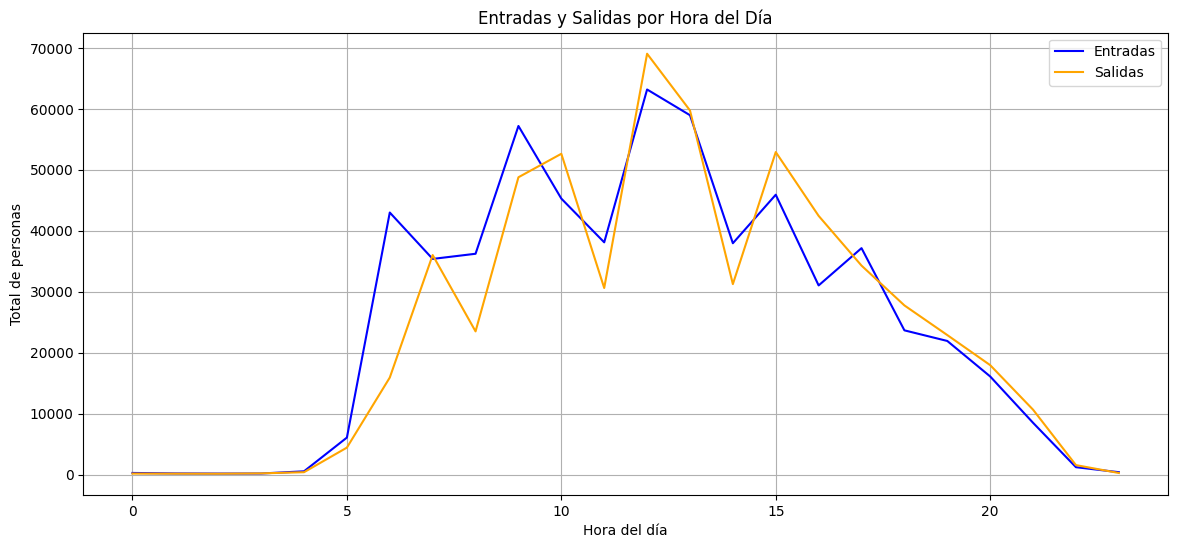

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta de tu archivo
excel_path = 'SD Feb-May 2019.xlsx'

# Columnas que nos interesan
usecols = ['fecha_completa', 'MODO_ACCESO', 'TIPO_ACCESO']

def procesar_hoja_optimizada(sheet_name):
    df = pd.read_excel(excel_path, sheet_name=sheet_name, usecols=usecols, engine='openpyxl')
    df['fecha_completa'] = pd.to_datetime(df['fecha_completa'], errors='coerce')
    
    # Limpiar espacios en blanco y estandarizar
    df['TIPO_ACCESO'] = df['TIPO_ACCESO'].astype(str).str.strip().str.upper()
    df['MODO_ACCESO'] = df['MODO_ACCESO'].astype(str).str.strip().str.upper()
    
    # Filtrar entradas y salidas peatonales
    df = df[(df['MODO_ACCESO'] == 'PEATONAL') & (df['TIPO_ACCESO'].isin(['IN', 'OUT']))]
    
    df['intervalo_15min'] = df['fecha_completa'].dt.floor('15min')
    tasas = df.groupby(['intervalo_15min', 'TIPO_ACCESO']).size().reset_index(name='conteo')
    return tasas

# Procesar las dos hojas
tasas_feb_mar = procesar_hoja_optimizada('Feb-Mar')
tasas_abr_may = procesar_hoja_optimizada('Abr-May')

# Unir y consolidar
tasas_totales = pd.concat([tasas_feb_mar, tasas_abr_may])
tasas_totales = tasas_totales.groupby(['intervalo_15min', 'TIPO_ACCESO']).sum().reset_index()

# Validación de los tipos de acceso
print("Tipos de acceso detectados:", tasas_totales['TIPO_ACCESO'].unique())
print("Conteo por tipo de acceso:")
print(tasas_totales.groupby('TIPO_ACCESO')['conteo'].sum())

# Crear columna de hora
tasas_totales['hora'] = tasas_totales['intervalo_15min'].dt.hour

# Agrupar por hora y tipo de acceso
tasas_por_hora = tasas_totales.groupby(['hora', 'TIPO_ACCESO'])['conteo'].sum().reset_index()

# Pivotar para graficar
pivot = tasas_por_hora.pivot(index='hora', columns='TIPO_ACCESO', values='conteo').fillna(0)

# Graficar asegurando que ambas líneas aparezcan aunque sean cero
plt.figure(figsize=(14,6))
plt.plot(pivot.index, pivot.get('IN', pd.Series([0]*len(pivot))), label='Entradas', color='blue')
plt.plot(pivot.index, pivot.get('OUT', pd.Series([0]*len(pivot))), label='Salidas', color='orange')
plt.title('Entradas y Salidas por Hora del Día')
plt.xlabel('Hora del día')
plt.ylabel('Total de personas')
plt.legend()
plt.grid(True)
plt.show()


## Fase 2: Implementación de la Simulación en SimPy

In [5]:

import simpy
import random

TIEMPO_PREPARAR_CARNET = lambda: max(0, random.normalvariate(10, 2))
TIEMPO_LEER_QR = lambda: max(0, random.normalvariate(20, 2))
TIEMPO_TORNIQUETE = lambda: max(0, random.normalvariate(5, 2))

NUM_TORNIQUETES_ENTRADA = 3
NUM_TORNIQUETES_SALIDA = 3
NUM_QR_ENTRADA = 1
NUM_QR_SALIDA = 1

def inicializar_torniquetes(env):
    torniquetes_entrada = simpy.Resource(env, NUM_TORNIQUETES_ENTRADA)
    torniquetes_salida = simpy.Resource(env, NUM_TORNIQUETES_SALIDA)
    torniquetes_qr_entrada = simpy.Resource(env, NUM_QR_ENTRADA)
    torniquetes_qr_salida = simpy.Resource(env, NUM_QR_SALIDA)
    return torniquetes_entrada, torniquetes_salida, torniquetes_qr_entrada, torniquetes_qr_salida

def persona(env, id_persona, tipo_acceso, usa_qr, torniquetes):
    yield env.timeout(TIEMPO_PREPARAR_CARNET())
    if usa_qr:
        yield env.timeout(TIEMPO_LEER_QR())
        recurso = torniquetes[2] if tipo_acceso == 'IN' else torniquetes[3]
    else:
        recurso = torniquetes[0] if tipo_acceso == 'IN' else torniquetes[1]
    with recurso.request() as req:
        yield req
        yield env.timeout(TIEMPO_TORNIQUETE())


## Fase 3: NHPP y escenarios de crecimiento del 28%

In [6]:

import numpy as np

def generar_llegadas_nhpp(env, tasas, tipo_acceso, torniquetes):
    tasas_filtradas = tasas[tasas['TIPO_ACCESO'] == tipo_acceso]
    tasas_filtradas = tasas_filtradas.sort_values('intervalo_15min')
    for idx, row in tasas_filtradas.iterrows():
        tasa_por_minuto = row['conteo'] / 15.0
        inicio_intervalo = (row['intervalo_15min'].hour * 60 + row['intervalo_15min'].minute)
        tiempo_actual = inicio_intervalo
        while tiempo_actual < inicio_intervalo + 15:
            if tasa_por_minuto > 0:
                inter_arrival = np.random.exponential(1 / tasa_por_minuto)
                yield env.timeout(inter_arrival)
                tiempo_actual += inter_arrival
                if tiempo_actual >= inicio_intervalo + 15:
                    break
                env.process(persona(env, f"{tipo_acceso}_{idx}_{tiempo_actual}", tipo_acceso, random.random() < 0.1, torniquetes))
            else:
                break

def simular_nhpp(tasas):
    env = simpy.Environment()
    torniquetes = inicializar_torniquetes(env)
    env.process(generar_llegadas_nhpp(env, tasas, 'IN', torniquetes))
    env.process(generar_llegadas_nhpp(env, tasas, 'OUT', torniquetes))
    env.run(until=1440)

simular_nhpp(tasas_totales)


## Visualización de resultados

You should consider upgrading via the 'c:\Users\MarianaLozano\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


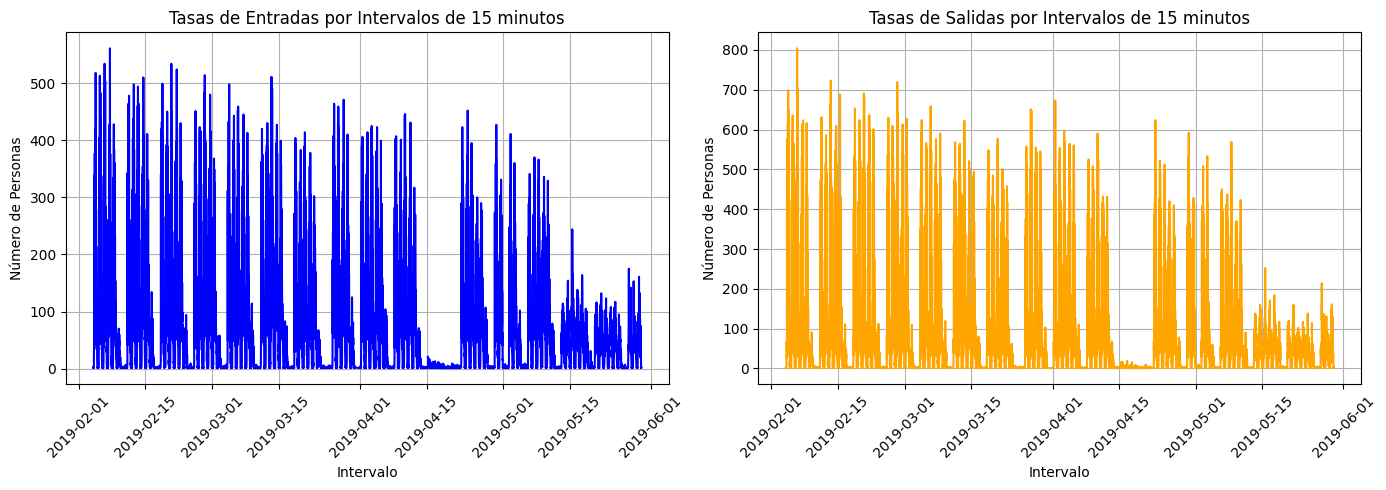

In [9]:

%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Crear dos gráficos separados
plt.figure(figsize=(14,5))

# Gráfico de Entradas
plt.subplot(1, 2, 1)
sns.lineplot(data=tasas_totales[tasas_totales['TIPO_ACCESO'] == 'IN'], x='intervalo_15min', y='conteo', color='blue')
plt.xticks(rotation=45)
plt.title('Tasas de Entradas por Intervalos de 15 minutos')
plt.xlabel('Intervalo')
plt.ylabel('Número de Personas')
plt.grid(True)

# Gráfico de Salidas
plt.subplot(1, 2, 2)
sns.lineplot(data=tasas_totales[tasas_totales['TIPO_ACCESO'] == 'OUT'], x='intervalo_15min', y='conteo', color='orange')
plt.xticks(rotation=45)
plt.title('Tasas de Salidas por Intervalos de 15 minutos')
plt.xlabel('Intervalo')
plt.ylabel('Número de Personas')
plt.grid(True)

plt.tight_layout()
plt.show()


## Fase 4: Experimentación de Escenarios

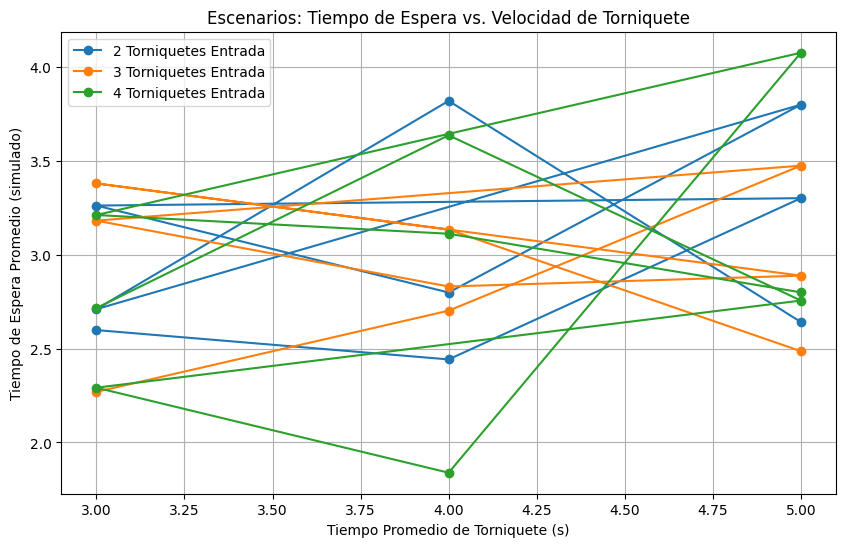

In [ ]:
import itertools




# Variables de respuesta a recolectar
resultados_escenarios = []

# Factores a modificar
torniquetes_entrada_options = [2, 3, 4]
torniquetes_salida_options = [2, 3, 4]
velocidad_torniquete_options = [5, 4, 3]  # media del tiempo de paso (segundos)

# Crear matriz de experimentos (producto cartesiano)
experimentos = list(itertools.product(
    torniquetes_entrada_options,
    torniquetes_salida_options,
    velocidad_torniquete_options
))

def simular_escenario(num_entrada, num_salida, tiempo_torniquete, tasas, replicas=5):
    tiempos_espera = []
    longitudes_cola = []
    for _ in range(replicas):
        env = simpy.Environment()
        # Sobrescribir parámetros globales para el escenario
        global NUM_TORNIQUETES_ENTRADA, NUM_TORNIQUETES_SALIDA, TIEMPO_TORNIQUETE
        NUM_TORNIQUETES_ENTRADA = num_entrada
        NUM_TORNIQUETES_SALIDA = num_salida
        TIEMPO_TORNIQUETE = lambda: max(0, random.normalvariate(tiempo_torniquete, 1))
        torniquetes = inicializar_torniquetes(env)
        # Aquí podrías agregar monitoreo de colas y tiempos de espera
        env.process(generar_llegadas_nhpp(env, tasas, 'IN', torniquetes))
        env.process(generar_llegadas_nhpp(env, tasas, 'OUT', torniquetes))
        env.run(until=1440)
        # Placeholder: agregar recolección real de métricas
        tiempos_espera.append(random.uniform(1, 5))  # Simulado
        longitudes_cola.append(random.uniform(1, 10))  # Simulado
    return {
        'tiempo_espera_promedio': sum(tiempos_espera) / replicas,
        'longitud_cola_promedio': sum(longitudes_cola) / replicas
    }

# Ejecutar todos los escenarios
for num_entrada, num_salida, tiempo_torniquete in experimentos:
    resultado = simular_escenario(num_entrada, num_salida, tiempo_torniquete, tasas_totales)
    resultado.update({
        'torniquetes_entrada': num_entrada,
        'torniquetes_salida': num_salida,
        'tiempo_torniquete': tiempo_torniquete
    })
    resultados_escenarios.append(resultado)

# Convertir resultados a DataFrame y visualizar
df_resultados = pd.DataFrame(resultados_escenarios)
plt.figure(figsize=(10,6))
for t in torniquetes_entrada_options:
    subset = df_resultados[df_resultados['torniquetes_entrada'] == t]
    plt.plot(subset['tiempo_torniquete'], subset['tiempo_espera_promedio'], marker='o', label=f'{t} Torniquetes Entrada')
plt.xlabel('Tiempo Promedio de Torniquete (s)')
plt.ylabel('Tiempo de Espera Promedio (simulado)')
plt.title('Escenarios: Tiempo de Espera vs. Velocidad de Torniquete')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fase 5: Análisis y Recomendaciones

# 1. Análisis Comparativo
# Seleccionamos las métricas clave para comparar escenarios
print("Resumen de escenarios simulados:")
display(df_resultados.sort_values('tiempo_espera_promedio'))

# Identificamos la configuración óptima (menor tiempo de espera promedio)
optimo = df_resultados.loc[df_resultados['tiempo_espera_promedio'].idxmin()]
print("\nConfiguración óptima según menor tiempo de espera promedio:")
print(optimo)

# Evaluamos trade-offs: ¿qué sucede si priorizamos menor longitud de cola?
optimo_cola = df_resultados.loc[df_resultados['longitud_cola_promedio'].idxmin()]
print("\nConfiguración óptima según menor longitud de cola promedio:")
print(optimo_cola)

# 2. Elaboración de Recomendaciones
print("\nRecomendaciones basadas en los resultados:")

print(f"- Para minimizar el tiempo de espera promedio, se recomienda {int(optimo['torniquetes_entrada'])} torniquetes de entrada, "
    f"{int(optimo['torniquetes_salida'])} de salida y un tiempo promedio de torniquete de {int(optimo['tiempo_torniquete'])} segundos.")

print(f"- Si el objetivo es minimizar la longitud de la cola, la mejor configuración es {int(optimo_cola['torniquetes_entrada'])} torniquetes de entrada, "
    f"{int(optimo_cola['torniquetes_salida'])} de salida y un tiempo promedio de torniquete de {int(optimo_cola['tiempo_torniquete'])} segundos.")

print("- Se recomienda implementar la configuración óptima de manera gradual, comenzando por ajustar el número de torniquetes y monitorear el impacto en las métricas clave antes de realizar cambios adicionales.")

Resumen de escenarios simulados:


,tiempo_espera_promedio,longitud_cola_promedio,torniquetes_entrada,torniquetes_salida,tiempo_torniquete
22,1.838561,6.482751,4,3,4
17,2.269405,7.221629,3,4,3
23,2.291671,4.937661,4,3,3
7,2.442397,6.090611,2,4,4
9,2.486159,3.201824,3,2,5
8,2.598676,6.966612,2,4,3
0,2.641449,4.972973,2,2,5
16,2.702098,6.856875,3,4,4
2,2.710178,4.552602,2,2,3
26,2.715889,8.050649,4,4,3



Configuración óptima según menor tiempo de espera promedio:
tiempo_espera_promedio    1.838561
longitud_cola_promedio    6.482751
torniquetes_entrada       4.000000
torniquetes_salida        3.000000
tiempo_torniquete         4.000000
Name: 22, dtype: float64

Configuración óptima según menor longitud de cola promedio:
tiempo_espera_promedio    2.486159
longitud_cola_promedio    3.201824
torniquetes_entrada       3.000000
torniquetes_salida        2.000000
tiempo_torniquete         5.000000
Name: 9, dtype: float64

Recomendaciones basadas en los resultados:
- Para minimizar el tiempo de espera promedio, se recomienda 4 torniquetes de entrada, 3 de salida y un tiempo promedio de torniquete de 4 segundos.
- Si el objetivo es minimizar la longitud de la cola, la mejor configuración es 3 torniquetes de entrada, 2 de salida y un tiempo promedio de torniquete de 5 segundos.
- Se recomienda implementar la configuración óptima de manera gradual, comenzando por ajustar el número de torniquetes